In [31]:
import random
import time
import numpy as np
from DemandPrediction import DemandPrediction
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position
        self.best_score = np.inf

class PSO:
    def __init__(self, num_particles, num_iterations, dataset_name):
        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.dataset_name = dataset_name
        self.bounds = DemandPrediction.bounds()
        self.particles = [Particle(self.random_position(), self.random_velocity()) for i in range(num_particles)]
        self.best_global_position = None
        self.best_global_score = np.inf

    def random_position(self):
        return [random.uniform(b[0], b[1]) for b in self.bounds]

    def random_velocity(self):
        return [random.uniform(-1, 1) for i in range(DemandPrediction.N_PARAMETERS)]

    def run(self):
        scores = []
        for i in range(self.num_iterations):
            scores.append(self.best_global_score)
            for particle in self.particles:
                if not DemandPrediction.is_valid(particle.position):
                    particle.position = self.random_position()
                if not DemandPrediction.is_valid(particle.velocity):
                    particle.velocity = self.random_velocity()

                score = DemandPrediction(self.dataset_name).evaluate(particle.position)
                if score < particle.best_score:
                    particle.best_position = particle.position
                    particle.best_score = score

                if score < self.best_global_score:
                    self.best_global_position = particle.position
                    self.best_global_score = score

                for j in range(DemandPrediction.N_PARAMETERS):
                    r1 = random.uniform(0, 1)
                    r2 = random.uniform(0, 1)
                    cognitive = 2.0
                    social = 2.0
                    velocity = (cognitive * r1 * (particle.best_position[j] - particle.position[j]) +
                                social * r2 * (self.best_global_position[j] - particle.position[j]))
                    particle.velocity[j] = velocity
                    particle.position[j] += velocity

        return self.best_global_position, self.best_global_score, scores

pso = PSO(num_particles=100, num_iterations=100, dataset_name="train")
start_time = time.time()
best_params, best_score, train_scores = pso.run()
end_time = time.time()
time_taken_train = end_time - start_time


start_time = time.time()
pso = PSO(num_particles=100, num_iterations=100, dataset_name="test")
best_params_test, best_score_test, test_scores = pso.run()
end_time = time.time()
time_taken_test = end_time - start_time



print("Best Train parameters found:", best_params)
print("Best Train score found:", best_score)
print('Time taken on train', time_taken_train)
print('')
print("Best Test parameters found:", best_params_test)
print("Best Test score found:", best_score_test)
print('Time taken on test', time_taken_test)

Best Train parameters found: [71.60662645707998, 40.20504194706522, -85.53342965866297, 45.90571630897908, -90.1055482754483, 5.167328883388748, -18.180093588417094, 45.699707439984635, -50.33544248536688, 25.81606935581102, -60.30737379185356, 12.051459486543369, 52.14556144900275, 78.29539920445826]
Best Train score found: 41.06360081954557
Time taken on train 16.788461208343506

Best Test parameters found: [89.16986381074916, 13.250904982253672, 41.751995792213584, 6.96952231461935, -94.09885547941741, -24.326300848553533, -65.01950861284898, -11.931834097167838, -23.930412560439027, -28.35358564689439, 7.820043540090099, 92.72504211363818, 12.524811485239434, 73.3008445285742]
Best Test score found: 39.78248325199149
Time taken on test 15.733652830123901


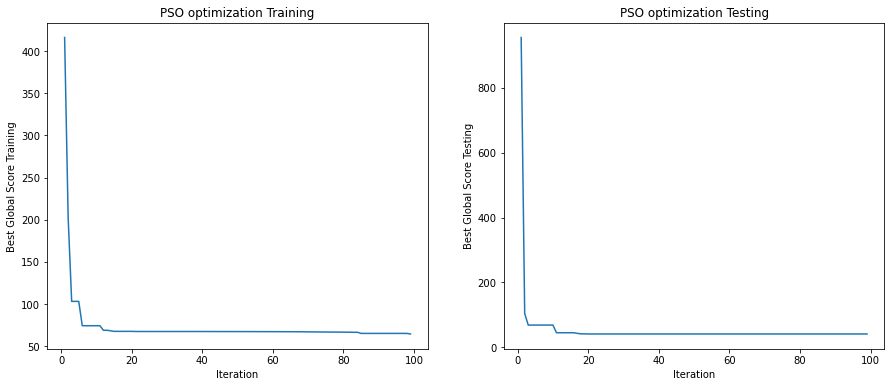

In [21]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(train_scores)
plt.title('PSO optimization Training')
plt.xlabel('Iteration')
plt.ylabel('Best Global Score Training')

plt.subplot(1,2,2)
plt.plot(test_scores)
plt.title('PSO optimization Testing')
plt.xlabel('Iteration')
plt.ylabel('Best Global Score Testing')
plt.show()

In [24]:
from scipy.stats import f_oneway, ttest_ind

def run_experiments(num_particles_list, num_iterations_list):
    results = []
    experiment_number = 1
    for num_particles in num_particles_list:
        for num_iterations in num_iterations_list:
            pso = PSO(num_particles=num_particles, num_iterations=num_iterations, dataset_name="train")
            pso_test = PSO(num_particles=num_particles, num_iterations=num_iterations, dataset_name="test")
            best_params, best_score, _ = pso.run()
            best_params_test, best_score_test, _ = pso_test.run()
            results.append({'num_particles': num_particles, 'num_iterations': num_iterations, 'MAE Train': best_score, 'MAE Test': best_score_test})
            
            print(f'########################## Experiment number: {experiment_number} ###############################')
            print(f"num_particles: {num_particles}, num_iterations: {num_iterations}")
            print(f"MAE on training dataset: {best_score}")
            print(f"MAE on test dataset: {best_score_test}")
            print('')
            
            experiment_number += 1

    best_scores_train = [r['MAE Train'] for r in results]
    best_scores_test = [r['MAE Test'] for r in results]
    particle_groups = [r['num_particles'] for r in results]
    iteration_groups = [r['num_iterations'] for r in results]

    # One-way ANOVA to test if there is a significant difference in scores between particle group means
    f_value, p_value = f_oneway(best_scores_train[:len(num_iterations_list)], best_scores_train[len(num_iterations_list):])
    print("One-way ANOVA results:")
    print("F-value: ", f_value)
    print("p-value: ", p_value)

    # T-test to test if there is a significant difference in scores between the two particle groups
    t_value, p_value = ttest_ind(best_scores_train[:len(num_iterations_list)], best_scores_train[len(num_iterations_list):])
    print("T-test results:")
    print("T-value: ", t_value)
    print("p-value: ", p_value)

    return results

In [25]:
import pandas as pd
data = run_experiments(num_particles_list=[20, 50, 100], num_iterations_list=[50, 100, 200])
df = pd.DataFrame.from_dict(data)

########################## Experiment number: 1 ###############################
num_particles: 20, num_iterations: 50
MAE on training dataset: 72.97217343508174
MAE on test dataset: 72.26070694477447

########################## Experiment number: 2 ###############################
num_particles: 20, num_iterations: 100
MAE on training dataset: 42.344630275179895
MAE on test dataset: 66.18354713505909

########################## Experiment number: 3 ###############################
num_particles: 20, num_iterations: 200
MAE on training dataset: 37.331663953894555
MAE on test dataset: 41.650368507687716

########################## Experiment number: 4 ###############################
num_particles: 50, num_iterations: 50
MAE on training dataset: 63.270355583997976
MAE on test dataset: 80.4842213172136

########################## Experiment number: 5 ###############################
num_particles: 50, num_iterations: 100
MAE on training dataset: 43.22993006899589
MAE on test dataset: 46.78770

In [29]:
sorted_df = df.sort_values(by=['MAE Test'])
sorted_df

,num_particles,num_iterations,MAE Train,MAE Test
8,100,200,34.168535,40.015828
2,20,200,37.331664,41.650369
4,50,100,43.229930,46.787700
7,100,100,39.367609,46.857111
5,50,200,44.370628,50.694229
6,100,50,48.243421,64.532704
1,20,100,42.344630,66.183547
0,20,50,72.972173,72.260707
3,50,50,63.270356,80.484221


## Results

The results of the one-way ANOVA test show that there is not a significant difference between the mean MAE scores of the hyperparameter configurations tested, as the F-value is quite small and the associated p-value is greater than the typical alpha level of 0.05. Therefore, we cannot reject the null hypothesis that there is no significant difference between the mean scores.

The results of the t-test show the same conclusion as the ANOVA test, but specifically between the two groups being compared (in this case, the group of MAE scores for the first set of hyperparameters and the group of MAE scores for the second set of hyperparameters). The t-value is also small and the associated p-value is greater than 0.05, indicating that we cannot reject the null hypothesis that there is no significant difference between the mean scores of the two groups.